In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan  4 15:27:13 2019

@author: hejia
"""
# stationary: mean, variance, autocorrelation are all constant
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt

Text(0, 0.5, 'AR')

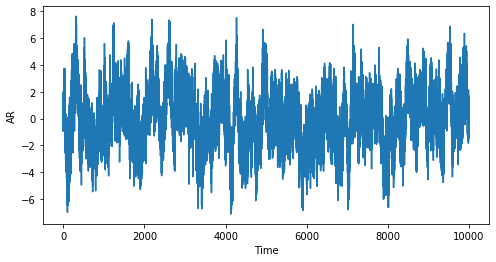

In [3]:
#X_t=b_0 + b_1 * x_t-1 + b_2 * x_t-2 + b_p * x_t-p + error
np.random.seed(100)
def AR(b,X,mu,sigma):
    length=min(len(b)-1,len(X))
    return b[0]+np.dot(b[1:length+1],X[-length:])+ np.random.normal(mu,sigma)
b=np.array([0,0.8,0.1,0.05])
X=np.array([1])
mu=0
sigma=1

for i in range(10000):
    X=np.append(X,AR(b,X,mu,sigma))
    
plt.figure(figsize=(8,4))
plt.plot(X)
plt.xlabel('Time')
plt.ylabel('AR')

In [4]:
# tail risk, AR tends to have more extreme values than data from a normal distribution.
#becasue the value will stay up and affect more values.
def compare_AR_normal(X):
    A=np.zeros((2,4))
    for k in range(4):
        A[0,k]=len(X[X>k+1])/float(len(X)) # estimate tails of X
        A[1,k]=1-stats.norm.cdf(k+1)
    print('extreme value in AR 1:{:.3f} ,2:{:.3f}, 3:{:.3f}, 4:{:.3f}'.format(*A[0]))
    print('extreme value in normal 1:{:.3f} ,2:{:.3f}, 3:{:.3f}, 4:{:.3f}'.format(*A[1]))
    return A

compare_AR_normal(X)

extreme value in AR 1:0.328 ,2:0.185, 3:0.091, 4:0.036
extreme value in normal 1:0.159 ,2:0.023, 3:0.001, 4:0.000


array([[3.27567243e-01, 1.85481452e-01, 9.09909009e-02, 3.57964204e-02],
       [1.58655254e-01, 2.27501319e-02, 1.34989803e-03, 3.16712418e-05]])

In [5]:
# check whether the mean of X is stationary
def compute_unajusted_interval(X): # 95% boundaries 
    mu=np.mean(X)
    sigma=np.std(X)
    lower=mu-1.96* sigma/np.sqrt(len(X))
    upper=mu+1.96* sigma/np.sqrt(len(X))
    return lower,upper

def check_coverage(X):
    lower,upper=compute_unajusted_interval(X)
    return True if 0<=upper and 0>=lower else False

def simulate_AR_process(b,T):
    X=np.array([1])
    mu=0
    sigma=1
    for i in range(T):
        X=np.append(X,AR(b,X,mu,sigma))
    return X

trials=1000
outcomes=np.zeros((trials,1))

for i in range(trials):
    Z=simulate_AR_process(np.array([0,0.8,0.1,0.05]),100)
    if check_coverage(Z):
        outcomes[i]=1
    else:
        outcomes[i]=0
np.sum(outcomes)/trials

0.193

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Autocorrelations: 
 [1.         0.57070553 0.58001725 0.88553976 0.55669882 0.57640436
 0.78307405 0.54759415 0.55254723 0.70158722 0.53082572 0.52673077
 0.62850967 0.50091633 0.48541475 0.56544198 0.46391848 0.45390828
 0.51491108 0.43375521 0.43938017 0.46783793 0.40843913 0.42270738
 0.42566802 0.38298857 0.38379558 0.40029717 0.36548704 0.36088258
 0.37743521 0.34745858 0.34065687 0.35239327 0.33194099 0.31758452
 0.33113111 0.31688646 0.2818213  0.31237461 0.31252031]
Partial Autocorelations :
 [ 1.          0.57127624  0.37827414  0.80672256  0.00162478  0.00490887
 -0.04497956  0.04013524 -0.05301909  0.00706455 -0.00528104  0.0051476
 -0.03421094 -0.03637203 -0.06841025  0.00396849 -0.02433695  0.03906542
  0.02344142  0.02958713  0.07306916 -0.01201434  0.00279546  0.01328444
 -0.00679875 -0.01547705 -0.09186641  0.05847768  0.03298422  0.04395628
 -0.01605778  0.00286143 -0.00734411 -0.01496441  0.01152254 -0.01185183
  0.01895763  0.01901218 -0.09532658  0.00791091  0.06173

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


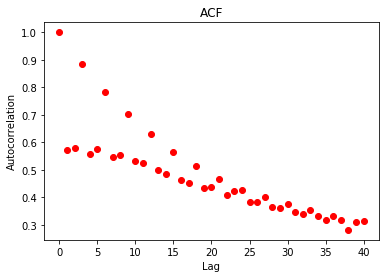

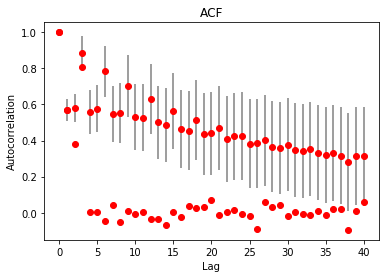

In [6]:
# autocorrelation function and partial autocorrelation function
from statsmodels.tsa.stattools import acf,pacf
X=simulate_AR_process(np.array([0,0.8,0.1,0.05]),1000)
# choose 40 lags
nlags=40
X_acf=acf(X,nlags=nlags)
print('Autocorrelations: \n {}'.format(X_acf))

X_pacf=pacf(X,nlags=nlags)
print('Partial Autocorelations :\n {}'.format(X_pacf))

plt.figure()
plt.plot(X_acf,'ro')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF')   

plt.figure()
plt.plot(X_pacf,'ro')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF')   

# check confidence level for acf and pacf
X_acf, X_acf_confs=acf(X,nlags=nlags,alpha=0.05)
X_pacf,X_pacf_confs=pacf(X,nlags=nlags,alpha=0.05)

def plot_acf(X_acf, X_acf_confs, title='ACF'):
    # The confidence intervals are returned by the functions as (lower, upper)
    # The plotting function needs them in the form (x-lower, upper-x)
    errorbars = np.ndarray((2, len(X_acf)))
    errorbars[0, :] = X_acf - X_acf_confs[:,0]
    errorbars[1, :] = X_acf_confs[:,1] - X_acf

    plt.plot(X_acf, 'ro')
    plt.errorbar(range(len(X_acf)), X_acf, yerr=errorbars, fmt='none', ecolor='gray', capthick=2)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title);
plot_acf(X_acf, X_acf_confs)